In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
set_global_seed(42)
data_path_1 = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"
data_path_2 = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"
data_paths = [data_path_1, data_path_2]
# train_percentage=100 makes test and val 100 as well
splits = split_participants(data_paths, train_percentage=60)
labels = SAT_CLASSES_ACCURACY
info_to_keep = ["event_name", "rt"]
whole_epoch = True
subset_cond = "accuracy"

In [3]:
norm_fn = norm_mad_zscore
train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
)
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
)

In [4]:
# model = SAT1GRU(19, 5)
model = MambaModel(256, 19, len(labels), 5, global_pool=False, dropout=0.1)
# 2 workers, ~18 b/s
# 4 workers, ~35 b/s
# 8 workers, ~48 b/s
# 12 workers, ~48 b/s
train_and_test(
    model,
    train_data,
    test_data,
    val_data,
    logs_path=Path("../logs/"),
    workers=8,
    batch_size=64,
    labels=labels,
    lr=0.0001,
    # label_smoothing=0.1,
    # weight_decay=0.0001,
    do_spectral_decoupling=False,
    use_class_weights=False,
    class_weights=class_weights,
    whole_epoch=True,
)

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

  0%|          | 0/167 [00:00<?, ? batch/s]

[]

In [6]:
model = SAT1GRU(64, 5)

train_and_test(
    model,
    train_data,
    test_data,
    val_data,
    logs_path=Path("../logs/"),
    workers=0,
    batch_size=128,
    labels=SAT_CLASSES_ACCURACY,
    label_smoothing=0.0001,
    weight_decay=0.01,
    lr=0.001,
    do_spectral_decoupling=False,
    use_class_weights=True,
    class_weights=class_weights,
)

  0%|          | 0/568 [00:00<?, ? batch/s]

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 577, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 312, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/opt/conda/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2070, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/opt/conda/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2106, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


In [ ]:
chk_path = Path("../models/gru100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(dataset_sat1.channels),
    "n_samples": len(dataset_sat1.samples),
    "n_classes": len(dataset_sat1.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

In [17]:
test_loader = DataLoader(test_data, 128, shuffle=False, num_workers=4, pin_memory=True)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

In [22]:
test_loader = DataLoader(
    train_dataset_sat1, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

0.5499136057075972


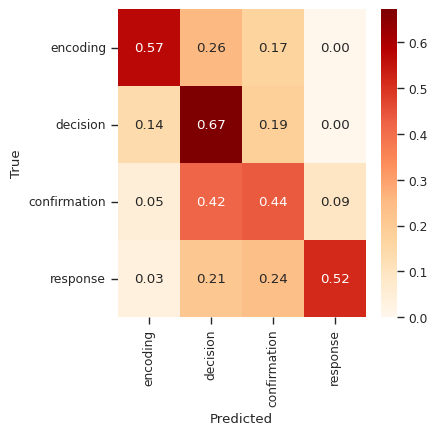

In [18]:
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY[1:])